# Face Detection with OpenCV

OpenCV is one of the most popular libraries for Computer Vision. Originally written in C/C++, it now provides bindings for Python. In this Notebook we will install OpenCV, explain what color models are, manipulate the pictures (for extracting some useful information from them) and draw figures on images. As a final step we will try to do face detection with photos of some famous Belgian athletes.

## 1. Installation

First things first, let’s install OpenCV.

In [2]:
pip install opencv-python opencv-contrib-python


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


After you finish the installation, try importing the package to see if it works well. If you get the return without any errors, then you’re now ready to go!

In [3]:
import cv2
cv2.__version__

'4.6.0'

The first step we’re going to do with OpenCV is importing an image and plot it using *Matplotlib*.

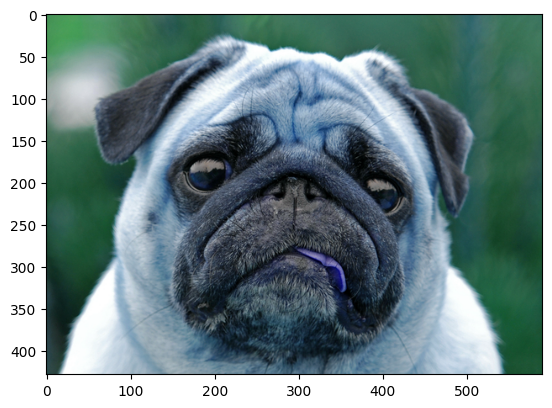

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import the image
img_orig = cv2.imread('resources/dog.jpg')
plt.imshow(img_orig)

## 2. Color Models

Our dog looks a little bit strange. The default setting of the color mode in OpenCV comes in the order of BGR, which is different from that of Matplotlib. Therefore to see the image in RGB mode, we need to convert it from BGR to RGB as follows.

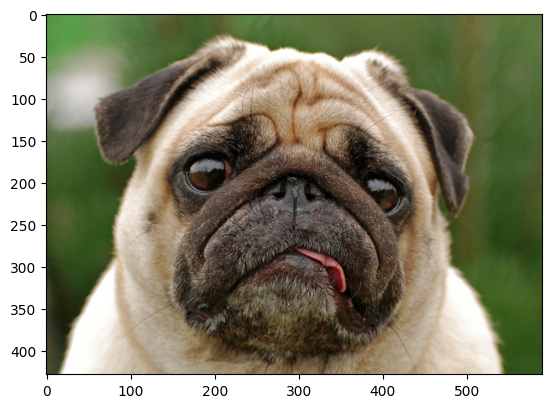

In [5]:
# convert the image from BGR into RGB
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

A color model is a system for creating a full range of colors using primary colors. Additive models use light to represent colors in computer screens while subtractive models use inks to print those digital images on papers. The primary colors are red, green and blue (RGB) for the first one and cyan, magenta, yellow and black (CMYK) for the latter one. All the other colors we see on images are made by combining or mixing these primary colors.

<img src="./resources/colormodels.png" style="height: 250px"/>

A grayscale is another simple color model quite often used in Computer Vision. It represents images and morphologies by the intensity of black and white, which means it has only one channel.

(-0.5, 589.5, 427.5, -0.5)

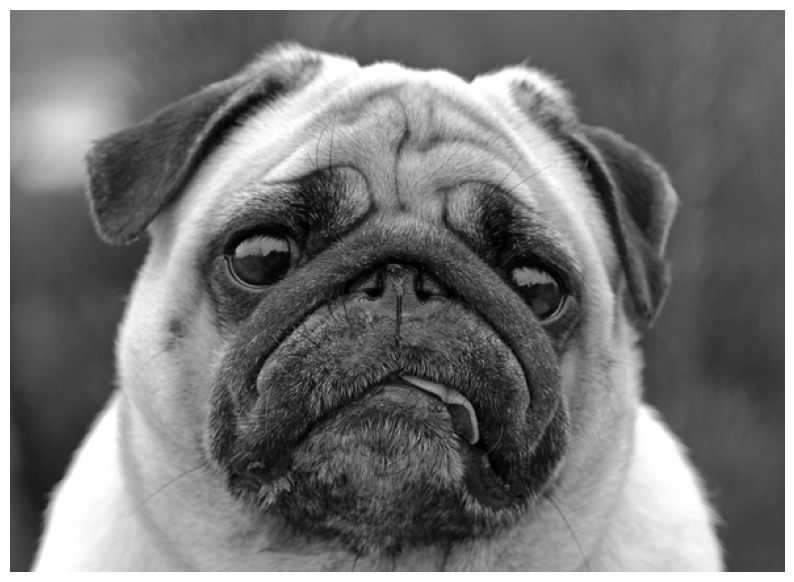

In [6]:
# convert the image into gray scale
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (10, 10))
plt.imshow(img_gray, cmap = 'gray')
plt.axis('off')

## 3. Drawing on images

Using OpenCV you can draw figures on images. We will only demonstrate the drawing of a rectangle, but you can of course draw circles, put texts, ... as well. You will use the other methods in the exercise.

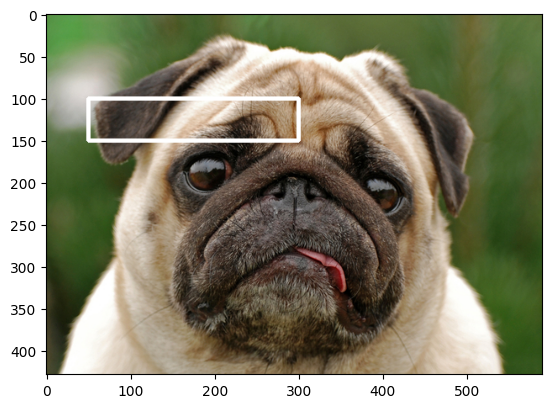

In [7]:
color = (255, 255, 255)
line_thickness = 3

x1 = 50
y1 = 100 # upperleft corner

x2 = 300
y2 = 150 # lowerright corner

cv2.rectangle(img_rgb, (x1, y1), (x2, y2), 
              color, line_thickness)
plt.imshow(img_rgb)

### Exercise

Try to draw a circle arround the nose of the dog.

In [ ]:
# draw a circle


## 4. Edge detection

In the previous Notebook we explained how you can use convolution filters to compute a feature map that can be used for feature detection. *Canny detection* is one of the most popular algorithms for detecting edges. It is a combination of four different filters like noise reduction, thresholding, ...

(-0.5, 589.5, 427.5, -0.5)

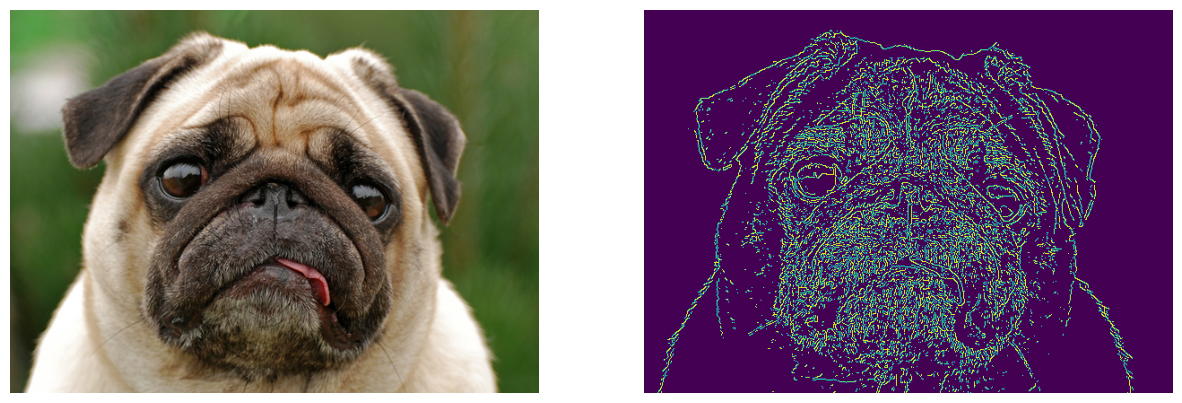

In [8]:
img_orig = cv2.imread('resources/dog.jpg')
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# canny detection without blurring
img_canny = cv2.Canny(img_rgb, threshold1=127, threshold2=127)
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1); plt.imshow(img_rgb)
plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(img_canny)
plt.axis('off')

Given the two different threshold values, we get three ranges of values. So if the intensity gradient of a point is higher than the upper threshold, it will be considered as ‘sure-edge.’ If the gradient of a point is lower than the lower threshold, the point will be discarded. And in case of the gradient being in the middle of the two thresholds, we see its connectivity to other ‘sure-edge’ points. If there’s no connection, it will be discarded as well. We just used the median value for the two thresholds (127) without blurring and the result isn’t quite desirable.

Let's play arround with the lower and upper threshold values, use blurring to reduce noise and apply two different sizes of kernels: (3x3) and (5x5). By the way, the kernel size is normally always odd.

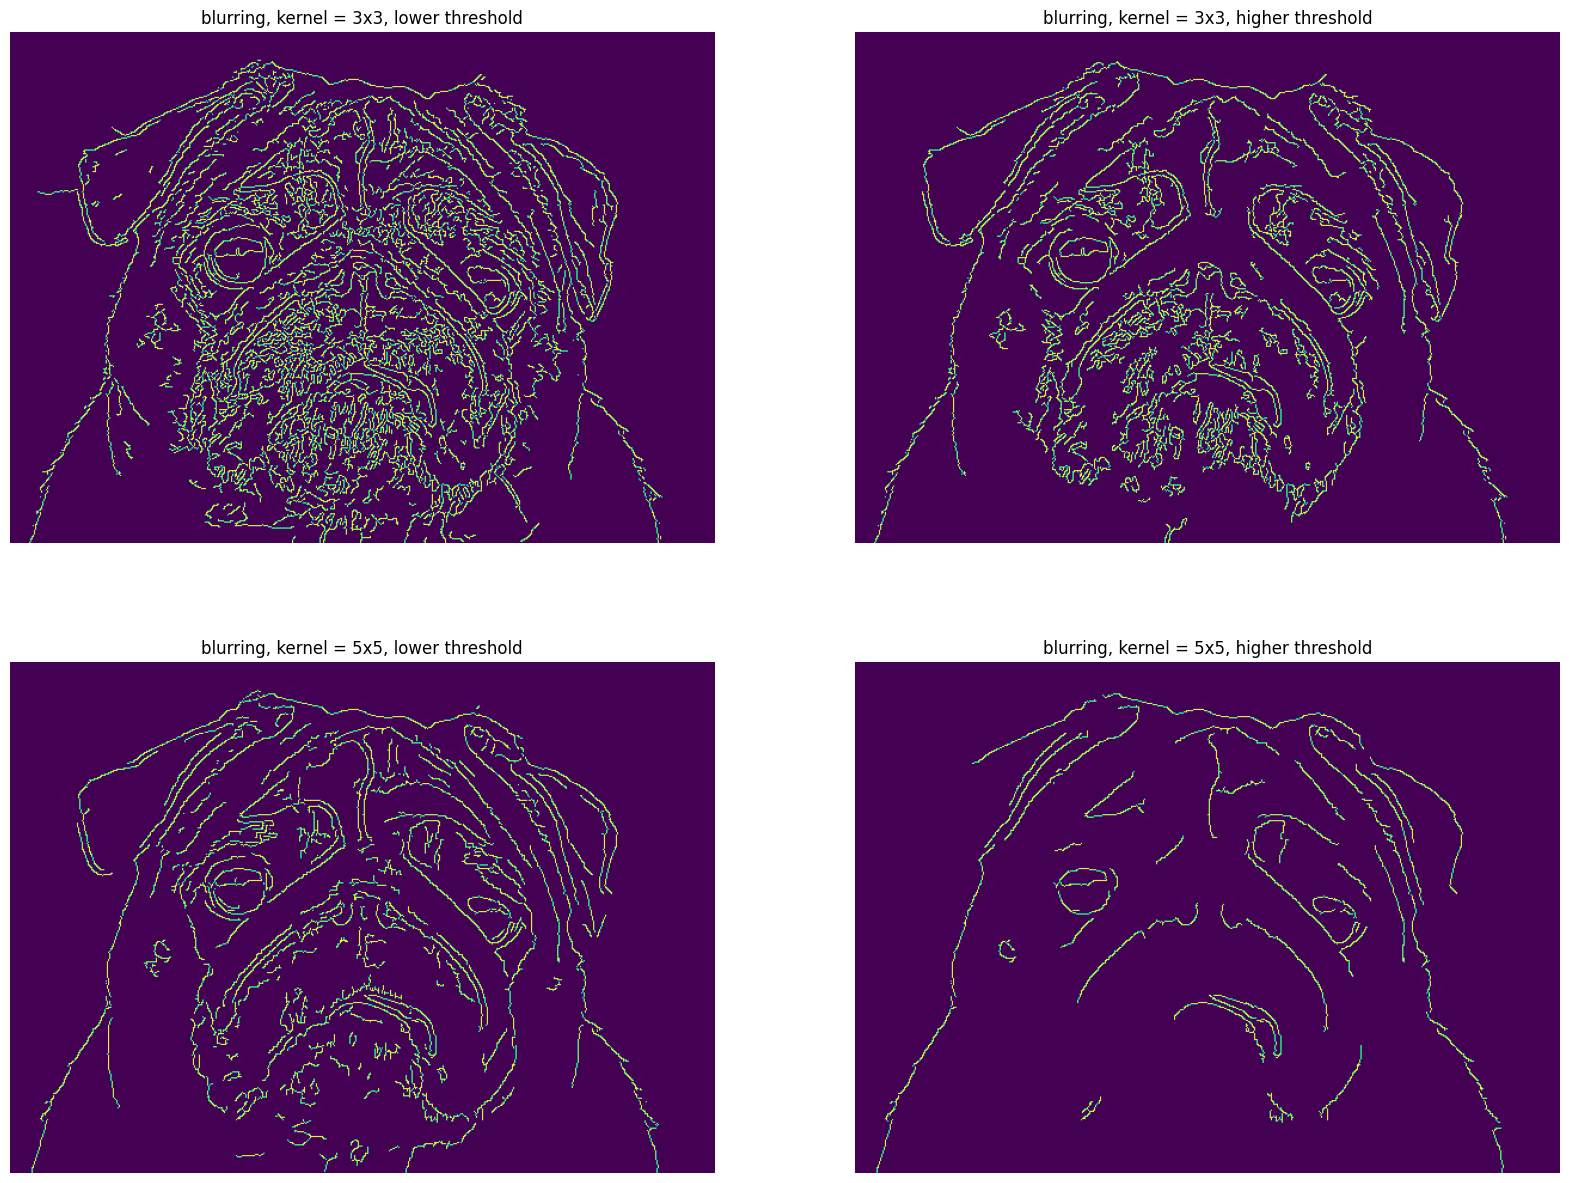

In [9]:
# set the lower and upper threshold
med_val = np.median(img_orig)
lower = int(max(0, .7 * med_val))
upper = int(min(255, 1.3 * med_val))

# blurring with ksize = 3
img_k3 = cv2.blur(img_orig, ksize = (3, 3))
# canny detection with different thresholds
edges_k3 = cv2.Canny(img_k3, threshold1 = lower, threshold2 = upper)
edges_k3_2 = cv2.Canny(img_k3, lower, upper + 75)

# blurring with ksize = 5 
img_k5 = cv2.blur(img_orig, ksize = (5, 5))
# canny detection with different thresholds
edges_k5 = cv2.Canny(img_k5, lower, upper)
edges_k5_2 = cv2.Canny(img_k5, lower, upper + 75)

# plot the images
images = [edges_k3, edges_k3_2, edges_k5, edges_k5_2]
titles = ['blurring, kernel = 3x3, lower threshold', 
          'blurring, kernel = 3x3, higher threshold', 
          'blurring, kernel = 5x5, lower threshold', 
          'blurring, kernel = 5x5, higher threshold']
plt.figure(figsize = (20, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(titles[i])
        
plt.show()

As you can see above, blurring helps to remove noise and we got the best results with the (5x5) filter with the lower threshold.

## 5. Face detection

Face detection is a technology identifying the presence and the position of human faces in digital images. Face recognition  indicates detecting the identification of a person by his or her face. So face detection can’t tell us to whom the detected face belongs. Face recognition will be covered in the next Notebook.

## Cascades

Because faces are so complicated, there isn’t one simple test that will tell you if a face is found or not. Instead, there are thousands of small patterns and features that must be matched. The algorithms break the task of identifying the face into thousands of smaller, bite-sized tasks, each of which is easy to solve. These tasks are also called classifiers.

For something like a face, you might have 6,000 or more classifiers, all of which must match for a face to be detected. But therein lies the problem: for face detection, the algorithm starts at the top left of a picture and moves down across small blocks of data, looking at each block, constantly asking, “Is this a face? … Is this a face? … Is this a face?” Since there are 6,000 or more tests per block, you might have millions of calculations to do, which will grind your computer to a halt.

To get around this, OpenCV uses cascades. Like a series of waterfalls, the OpenCV cascade breaks the problem of detecting faces into multiple stages. For each block, it does a very rough and quick test. If that passes, it does a slightly more detailed test, and so on. The advantage is that the majority of the picture will return a negative during the first few stages, which means the algorithm won’t waste time testing all 6,000 features on it. Instead of taking hours, face detection can now be done in real time.

## 6. Red Lions

Let's try to detect all the faces of the Red Lions, the Belgian national men's field hockey team, who won the Men's Hockey World Cup in 2018 and the European Championship in 2019.

We first convert the image into grayscale and use the Haar Cascade classifier to detect faces and draw a rectangle around them. 

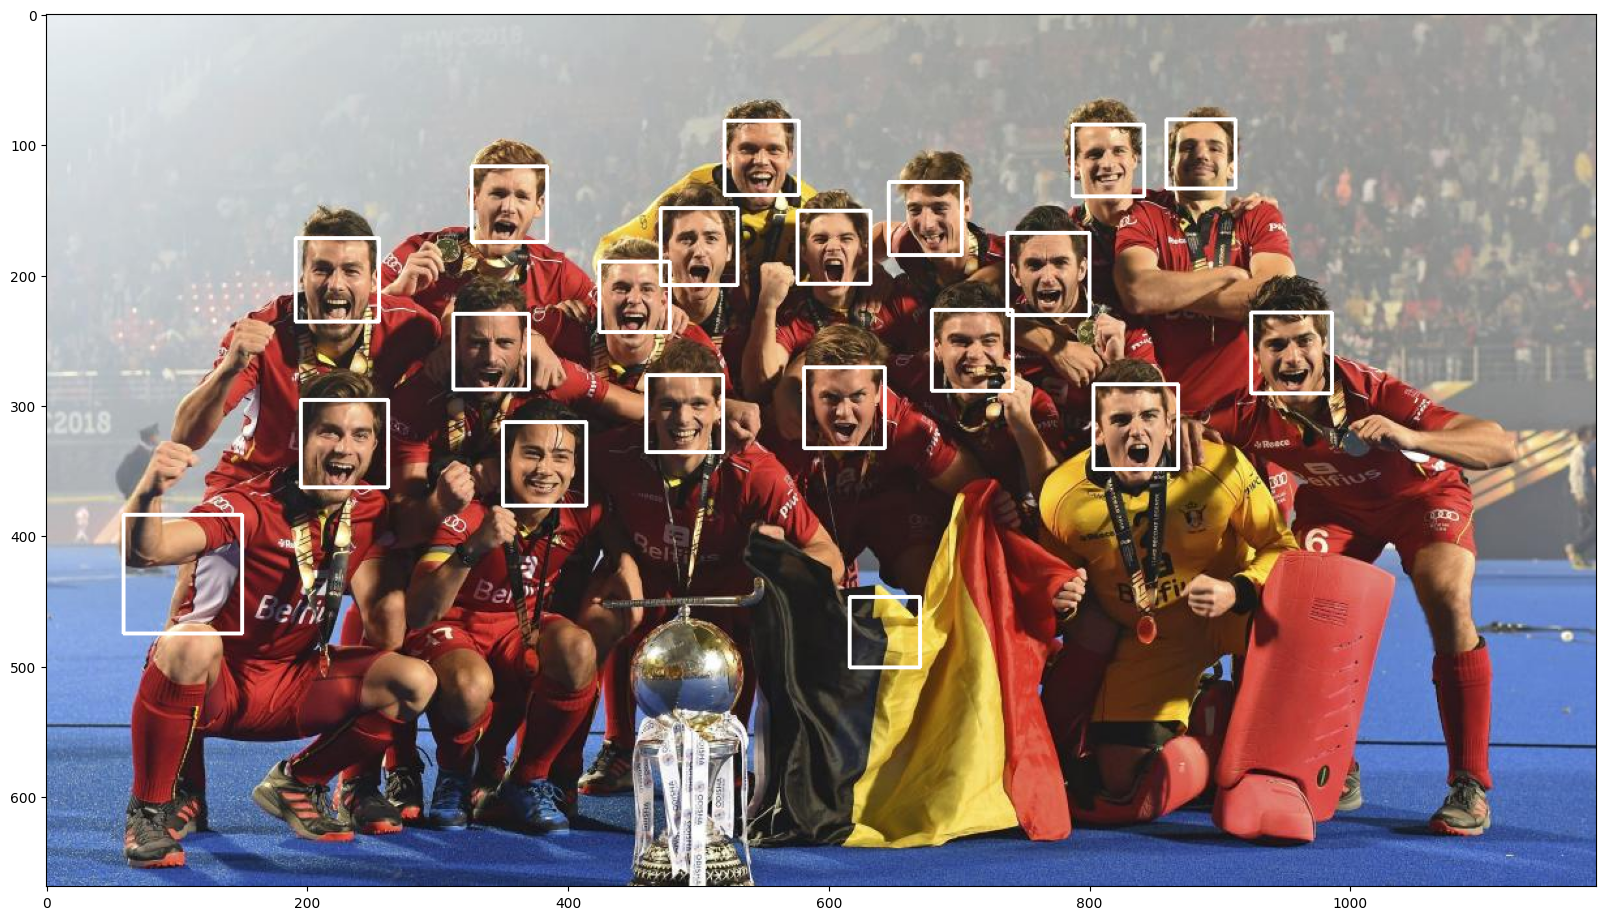

In [10]:
classifier = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
img_orig = cv2.imread('resources/redlions.jpg')

img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

regions = classifier.detectMultiScale(img_gray, 
                                      1.1, #  scaleFactor is a parameter for how much the image size is reduced 
                                      3) # minNeighbors for how many neighbors each candidate rectangle should be trained

for (x, y, w, h) in regions:
    img_rgb = cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 255, 255), 2) 

plt.figure(figsize = (20,20))
plt.imshow(img_rgb)

## 7. Nafi Thiam - Exercise

Now use the __eye classifier__ (in the `haarcascades` folder) on a photo of Nafi Thiam (you can find the jpg in the resources), our gold medal heptathlon athlete at the 2016 Summer Olympics, the 2017 World Championships and the 2018 European Championships.

Play around with the two parameters (`scaleFactor` and `minNeighbors`) and try to capture (only) the two eyes of our gold medalist.

## 8. Want to try yours?

Would you like to try yours with a Webcam? We can apply the same process. You can shut down the window by pressing ESC.

In [ ]:
import cv2
import numpy as np

# step 1: define detect function
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

def detect_face(img):
    
    img_copy = img.copy()
    face_rects = face_cascade.detectMultiScale(img_copy)
    
    for (x, y, w, h) in face_rects:
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 255, 255), 3)
        
    return img_copy

# step 2: call the cam
cap = cv2.VideoCapture(0) 

while True: 
    
    ret, frame = cap.read(0) 
     
    frame = detect_face(frame)
    cv2.imshow('Video Face Detection', frame) 
 
    c = cv2.waitKey(1) 
    if c == 27: 
        break 
        
cap.release() 
cv2.destroyAllWindows()

## 9. Exercise

In the `haarcascades` directory you will find other classifiers. Try the __body classifier__ and and apply it on a photo you've taken yourself.